In [2]:
import numpy as np
import scipy.linalg as la
import pandas as pd
import scipy.stats as stats
import time
import cPickle as pickle
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style='white', palette = 'colorblind', color_codes=True)

In [3]:
# functions to create synthetic datasets

def sbm_adjacency(nA, dA, lamA):
    v = np.ones(nA)
    v[0:int(np.floor(nA/2))] =-1.0
    expectedA = np.ones((nA, nA))*(dA/nA) + lamA*np.sqrt(dA)*np.outer(v, v)/nA
    unifs = np.tril(np.random.rand(nA, nA))
    unifs = unifs + unifs.T
    A = (expectedA> unifs)
    A = A.astype(float)
    A = A - np.diag(np.diag(A))
    
    return A, v


def sbm_covariates(nB, pB, vB, muB):
    # nB should be the length vB
    u = np.random.randn(pB)
    B = np.sqrt(muB/(nB*pB))*np.outer(u, vB) + np.random.randn(pB, nB)/np.sqrt(pB)
    return B, u

In [10]:
# functions to create test matrices from synthetic data

def nonbacktracking_from_adj(nbA):
    # input is symmetric zero one adjacency matrix. make it sparse.
    row_inds, col_inds = np.nonzero(nbA) # this gets both directed and undirected edges
    n_dedges = len(row_inds)
    NBW = np.zeros((n_dedges, n_dedges))
    for d_edge in range(n_dedges):
        tail = col_inds[d_edge]
        head = row_inds[d_edge]
        incoming_edges = np.logical_and(col_inds == head, row_inds != tail)
        NBW[d_edge, incoming_edges] = 1.0
    return NBW, row_inds, col_inds

def vertex_marginals_from_incoming_messages(n_vertices, vrow_inds, vcol_inds):
    # creates linear transform for computing unnormalized vertex marginals from incoming messages
    mat_out = np.zeros((n_vertices, len(vrow_inds))) 
    for ind in range(n_vertices):
        incoming_edges = (vcol_inds == ind).astype(float)
        mat_out[ind, :] = incoming_edges
    return mat_out

def dedge_messages_from_vertices(n_vertices, vrow_inds, vcol_inds):
    # expands vertex marginals to dedge messages in a linear fashion
    n_edges = len(vrow_inds)
    mat_out = np.zeros((n_edges, n_vertices))
    for ind in range(n_vertices):
        outgoing_edges = (vrow_inds==ind).astype(float)
        mat_out[:, ind] = outgoing_edges
    return mat_out  

def spectral_HT(A, B, nbW,vert_from_edges, edges_from_verts, n, p, n_edges, lam, mu, d):
    spectral_test = np.zeros((n_edges + n + n + p + p, n_edges + n+ n + p + p ))
    # the first row
    spectral_test[0:n_edges, 0:n_edges] = lam*nbW/np.sqrt(d)
    spectral_test[0:n_edges, n_edges:(n_edges+ n)] = -edges_from_verts.dot(lam*np.sqrt(d)*np.ones((n, n)))
    spectral_test[0:n_edges, (n_edges+n):(n_edges + 2*n)] = -edges_from_verts.dot(mu/gamma *np.eye(n))
    spectral_test[0:n_edges, (n_edges+2*n): (n_edges + 2*n+p)] = edges_from_verts.dot(B*np.sqrt(mu/gamma))
    # the second row
    spectral_test[n_edges:(n_edges+n), 0:n_edges] = lam*vert_from_edges/np.sqrt(d)
    spectral_test[n_edges:(n_edges+n), n_edges:(n_edges+ n)] = -lam*np.sqrt(d)*np.ones((n, n))
    spectral_test[n_edges:(n_edges + n), (n_edges+n):(n_edges + 2*n)] = -mu/gamma *np.eye(n)
    spectral_test[n_edges:(n_edges+n), (n_edges+2*n): (n_edges + 2*n+p)] = B*np.sqrt(mu/gamma)
    # the third row
    spectral_test[(n_edges+n):(n_edges+2*n),n_edges:(n_edges +n)] = np.eye(n)
    # the fourth row
    spectral_test[n_edges+2*n:(n_edges + 2*n + p), n_edges:(n_edges+n)] = B.T*np.sqrt(mu/gamma)
    spectral_test[n_edges+2*n:(n_edges + 2*n + p), (n_edges+2*n+p):(n_edges+2*n+2*p)] = -mu*np.eye(p)
    # the fifth row
    spectral_test[n_edges+2*n+p: n_edges+2*n+2*p , (n_edges+2*n):(n_edges+2*n+p) ] = np.eye(p)
    eigval_sp = la.eigvals(spectral_test)
    eigval_nontrival = eigval_sp[1:]
    return eigval_nontrival

def denoiser(eta, rho):
    # expects (vector) input eta and scalar input rho

    # threshold eta to be within machine allowance
    tol = 700
    eta[eta > tol] = tol
    eta[eta < -tol] = -tol
    # now compute log cos as required
    return 0.5*np.log(np.cosh(eta+rho))-0.5*np.log(np.cosh(eta - rho))


def one_BP_experiment(n, p, d, lam, mu, max_BP_iters, small_init=0.1):
    
    # sample one dataset from model
    A, v = sbm_adjacency(n, d, lam)
    B, u = sbm_covariates(n, p, v, mu)
    rho = np.arctanh(lam/np.sqrt(d))
    rho_n = np.arctanh(lam*np.sqrt(d)/(n-d))
    
    # create required auxiliary matrices from dataset
    NBW, row_inds, col_inds = nonbacktracking_from_adj(A)
    v_from_E = vertex_marginals_from_incoming_messages(n, row_inds, col_inds)
    E_from_v = dedge_messages_from_vertices(n, row_inds, col_inds)
    mBg = B*np.sqrt(mu/gamma)
    mBg2 = mBg**2
    
    # initialize BP variables
    n_edges = len(row_inds)
    eta_vertices = np.random.randn(n) *small_init
    eta_vertices_prev = np.random.randn(n) *small_init
    eta_edges = E_from_v.dot(eta_vertices)
    m_cov = np.random.randn(p)*small_init
    m_cov_prev = np.random.randn(p)*small_init
    tau_inv = 1+mu - mBg2.dot(1/np.cosh(eta_vertices_prev)**2)
    norms = np.zeros(max_BP_iters)

    # run max_BP_iters iterations of BP
    for BP_iter in range(max_BP_iters):
        norms[BP_iter] = la.norm(eta_vertices)/np.sqrt(n)
        eta_vertices_new = mBg.T.dot(m_cov) - mBg2.T.dot(tau_inv)*np.tanh(eta_vertices_prev) \
                           + v_from_E.dot(denoiser(eta_edges, rho)) - np.ones(n)*np.sum(denoiser(eta_vertices, rho_n), axis=0)
        eta_edges_new = E_from_v.dot(mBg.T.dot(m_cov) - mBg2.T.dot(tau_inv)*np.tanh(eta_vertices_prev)) \
                            + NBW.dot(denoiser(eta_edges, rho)) - np.ones(n_edges) *np.sum(denoiser(eta_vertices, rho_n), axis=0)
        tau_inv_new = 1+ mu -mBg2.dot(1/np.cosh(eta_vertices)**2)
        m_cov_new = (mBg.dot(np.tanh(eta_vertices)) -mBg2.dot(1/np.cosh(eta_vertices)**2)*m_cov_prev)*tau_inv_new

        # now update the variables
        eta_vertices_prev = eta_vertices
        eta_vertices = eta_vertices_new
        eta_edges = eta_edges_new
        m_cov_prev = m_cov
        m_cov = m_cov_new
    
    
    results = {}
    # now compute whatever statistics you want
    results['hypothesis'] = float(norms[-1] > small_init)
    results['overlap_v'] = np.abs(np.sign(eta_vertices).dot(v)/n)
    results['overlap_u'] = np.abs(np.dot(m_cov/la.norm(m_cov), u/la.norm(u)))
    
    return results
    
def grid_BP_experiment(n, p, d, nMc, lamGrid, muGrid, statsToCompute):
    gamma = np.float(n)/np.float(p)
    nGridLam = len(lamGrid)
    nGridMu = len(muGrid)
    results = {}
    for stat in statsToCompute:
        results[stat] = np.zeros((nGridLam, nGridMu, nMc))
        

    count = nMc*len(lamGrid)*len(muGrid)
    for mc in range(nMc):
        for lamIn, lam in enumerate(lamGrid):
            for muIn, mu in enumerate(muGrid):
                t= time.time()
                exptResult = one_BP_experiment(n, p, d, lam, mu, 50)
                count = count - 1
                elapsed = time.time() - t
                if count%10 == 0 :
                    print "Expected time remaining: {:.2f} hours".format(count*elapsed/3600.0) 
                for stat in statsToCompute:
                    results[stat][lamIn, muIn, mc] = exptResult[stat] 
    
    return results


In [ ]:
# set global experiment parameters
n = 800
p = 1000
gamma = np.float(n)/p
d = 5.0
nMc = 100

# create parameter grid
gridSpace = 30
lamGrid = np.linspace(0.001, 1, gridSpace)
muGrid = np.linspace(0.001, np.sqrt(gamma), gridSpace)

statsToCompute = ['hypothesis', 'overlap_v', 'overlap_u']

results = grid_BP_experiment(n, p, d, nMc, lamGrid, muGrid, statsToCompute)


In [14]:
results['overlap_v']

array([[[ 0.02  ],
        [ 0.0375],
        [ 0.045 ],
        [ 0.02  ]],

       [[ 0.0425],
        [ 0.005 ],
        [ 0.06  ],
        [ 0.0025]],

       [[ 0.0625],
        [ 0.0175],
        [ 0.01  ],
        [ 0.3975]],

       [[ 0.275 ],
        [ 0.0175],
        [ 0.3725],
        [ 0.6425]]])

In [98]:
# temporary data dump. replace this with hdf5 stuff!!

path = './'
filename = 'phase_transition.dat'
pickle.dump( results, open( path+filename, "wb" ) )





In [234]:
# set up some plotting configurations
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figspath = './figs/'
texpath = '../SLEPIANTEX/'
figsformat = 'png'


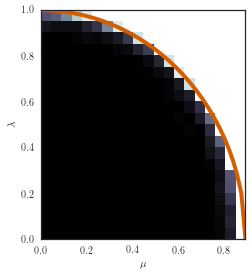

In [241]:
# plot hypothesis testing probabilities along with curve

fig, ax = plt.subplots()
im = ax.imshow(results['hypothesis'].mean(axis=2), 
              origin='lower', 
              cmap='bone',
              extent = [min(muGrid), max(muGrid), min(lamGrid), max(lamGrid)])

x = np.linspace(min(muGrid), max(muGrid), 50)
y = np.sqrt(1-x**2/gamma)
ax.plot(x, y, 'r', lw=4)
ax.set_ylim([min(lamGrid), max(lamGrid)])
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\lambda$')
fig.tight_layout()
filename = 'hyptesting_heatmap'
fig.savefig(figspath+filename+'.'+figsformat, format=figsformat, bbox_inches='tight')
fig.savefig(texpath+filename+'.'+figsformat, format=figsformat, bbox_inches='tight')

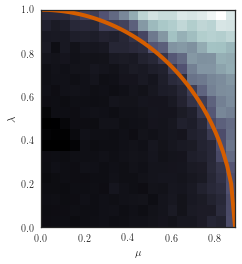

In [242]:
# plot overlap of v along with curve
fig, ax = plt.subplots()
im = ax.imshow(np.mean(results['overlap_v'], axis=2), 
              origin='lower', 
              cmap='bone',
              extent = [min(muGrid), max(muGrid), min(lamGrid), max(lamGrid)])

x = np.linspace(min(muGrid), max(muGrid), 50)
y = np.sqrt(1-x**2/gamma)
ax.set_ylim([min(lamGrid), max(lamGrid)])
ax.plot(x, y, 'r', lw=4)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\lambda$')

filename = 'overlapv_heatmap'
fig.savefig(figspath+filename+'.'+figsformat, format=figsformat, bbox_inches='tight')
fig.savefig(texpath+filename+'.'+figsformat, format=figsformat, bbox_inches='tight')

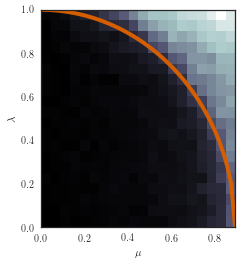

In [243]:
fig, ax = plt.subplots()
im = ax.imshow(np.mean(np.abs(results['overlap_u']), axis=2), 
              origin='lower', 
              cmap='bone',
              extent = [min(muGrid), max(muGrid), min(lamGrid), max(lamGrid)])

x = np.linspace(min(muGrid), max(muGrid), 50)
y = np.sqrt(1-x**2/gamma)
ax.set_ylim([min(lamGrid), max(lamGrid)])
ax.plot(x, y, 'r', lw=4)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\lambda$')

filename = 'overlapu_heatmap'
fig.savefig(figspath+filename+'.'+figsformat, format=figsformat, bbox_inches='tight')
fig.savefig(texpath+filename+'.'+figsformat, format=figsformat, bbox_inches='tight')

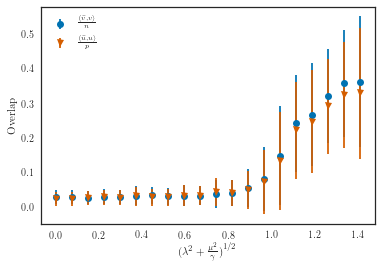

In [238]:
# plot recovery accuracy along a line

fig, ax = plt.subplots()
x = np.sqrt(lamGrid**2 + muGrid**2/gamma)
errors = np.std(results['overlap_v'][range(len(lamGrid)), range(len(muGrid)), :], axis = 1)
ax.errorbar(x, np.mean(results['overlap_v'][range(len(lamGrid)), range(len(muGrid)), :],axis=1), 
            errors, 
            fmt='bo', 
           label=r'$\frac{\langle{\widehat{v}, v}\rangle}{n}$') 
ax.errorbar(x, np.mean(np.abs(results['overlap_u'][range(len(lamGrid)), range(len(muGrid)), :]), axis=1), 
            errors, 
            fmt='rv', 
           label=r'$\frac{\langle\widehat{u}, u\rangle}{p}$') 
ax.set_xlabel(r'$\big(\lambda^2 + \frac{\mu^2}{\gamma}\big)^{1/2}$')
ax.set_ylabel(r'Overlap')
ax.legend(loc='upper left')


filename = 'overlaps_lineplot'
fig.savefig(figspath+filename+'.'+figsformat, format=figsformat)
fig.savefig(texpath+filename+'.'+figsformat, format=figsformat)

In [233]:
# initialize BP
n_edges = len(row_inds)
eta_vertices = np.random.randn(n)
eta_vertices_prev = np.random.randn(n)
eta_edges = E_from_v.dot(eta_vertices)
m_cov = np.random.randn(p)
m_cov_prev = np.random.randn(p)
tau_inv = 1+mu - mBg2.dot(1/np.cosh(eta_vertices_prev)**2)

# few iteration of BP
max_BP_iters = 100
for BP_iter in range(max_BP_iters):

    eta_vertices_new = mBg.T.dot(m_cov) - mBg2.T.dot(tau_inv)*np.tanh(eta_vertices_prev) \
                       + v_from_E.dot(denoiser(eta_edges, rho)) - sum(denoiser(eta_vertices, rho_n))
    eta_edges_new = E_from_v.dot(mBg.T.dot(m_cov) - mBg2.T.dot(tau_inv)*np.tanh(eta_vertices_prev)) \
                        + NBW.dot(denoiser(eta_edges, rho)) - sum(denoiser(eta_vertices, rho_n))
    tau_inv_new = 1+ mu -mBg2.dot(1/np.cosh(eta_vertices)**2)
    m_cov_new = (mBg.dot(np.tanh(eta_vertices)) -mBg2.dot(1/np.cosh(eta_vertices)**2)*m_cov_prev)*tau_inv_new

    # now update the variables
    eta_vertices_prev = eta_vertices
    eta_vertices = eta_vertices_new
    eta_edges = eta_edges_new
    m_cov_prev = m_cov
    m_cov = m_cov_new



In [195]:
results['overlap_u']

array([[[ -4.39048798e-03,  -8.74478284e-03,  -1.76518682e-03, ...,
          -2.27778435e-02,   2.58299161e-02,   4.59226627e-02],
        [  2.90822847e-02,   4.94058208e-03,   3.07084384e-02, ...,
           3.81120488e-02,  -2.19288930e-02,  -3.69672975e-02],
        [ -2.76649694e-02,  -3.85204776e-02,   2.41036812e-02, ...,
           3.72122851e-02,   1.32047930e-02,   9.54715750e-02],
        ..., 
        [  3.17727659e-03,   4.55453019e-02,   3.07972736e-02, ...,
          -4.30722383e-02,  -5.51605343e-02,   5.81654087e-02],
        [  7.79519383e-02,   2.79174104e-02,  -3.46952103e-02, ...,
           3.88172571e-02,  -3.40155812e-02,  -1.84106666e-02],
        [  4.36865011e-03,  -7.19790509e-02,   1.71053823e-01, ...,
          -1.85661681e-01,  -1.03888247e-01,  -2.48878827e-02]],

       [[ -3.20244406e-03,  -2.91659022e-02,  -1.61251459e-02, ...,
          -4.62099520e-02,   2.90609016e-02,  -3.55146184e-02],
        [  1.84665307e-02,  -3.66731542e-03,   8.07802603e-0

In [146]:

results['overlap_v']

array([[[ 0.0325,  0.0375,  0.085 , ...,  0.035 ,  0.005 ,  0.0125],
        [ 0.02  ,  0.0325,  0.0875, ...,  0.0225,  0.03  ,  0.035 ],
        [ 0.0075,  0.08  ,  0.005 , ...,  0.0475,  0.0025,  0.0775],
        ..., 
        [ 0.035 ,  0.035 ,  0.0225, ...,  0.0125,  0.055 ,  0.0525],
        [ 0.0475,  0.0675,  0.0275, ...,  0.0225,  0.0775,  0.0425],
        [ 0.0325,  0.1175,  0.075 , ...,  0.0325,  0.12  ,  0.075 ]],

       [[ 0.03  ,  0.0425,  0.0675, ...,  0.0025,  0.035 ,  0.0525],
        [ 0.0275,  0.0275,  0.02  , ...,  0.04  ,  0.005 ,  0.0225],
        [ 0.005 ,  0.0125,  0.015 , ...,  0.005 ,  0.0175,  0.02  ],
        ..., 
        [ 0.01  ,  0.0325,  0.0325, ...,  0.0425,  0.02  ,  0.09  ],
        [ 0.03  ,  0.165 ,  0.015 , ...,  0.1075,  0.0875,  0.0425],
        [ 0.1775,  0.345 ,  0.0025, ...,  0.2875,  0.3125,  0.0125]],

       [[ 0.035 ,  0.015 ,  0.1   , ...,  0.03  ,  0.0125,  0.015 ],
        [ 0.0475,  0.0475,  0.0275, ...,  0.0775,  0.0325,  0.0225],
  

(array([   1.,    0.,    0.,    5.,   14.,   11.,   16.,   35.,   46.,
          64.,   88.,  102.,  103.,  131.,  134.,  140.,  108.,  103.,
         103.,   80.,   60.,   55.,   39.,   30.,   15.,    9.,    4.,
           1.,    1.,    2.]),
 array([ -9.60172762e-03,  -8.96129094e-03,  -8.32085427e-03,
         -7.68041759e-03,  -7.03998091e-03,  -6.39954423e-03,
         -5.75910755e-03,  -5.11867088e-03,  -4.47823420e-03,
         -3.83779752e-03,  -3.19736084e-03,  -2.55692417e-03,
         -1.91648749e-03,  -1.27605081e-03,  -6.35614133e-04,
          4.82254437e-06,   6.45259222e-04,   1.28569590e-03,
          1.92613258e-03,   2.56656926e-03,   3.20700593e-03,
          3.84744261e-03,   4.48787929e-03,   5.12831597e-03,
          5.76875264e-03,   6.40918932e-03,   7.04962600e-03,
          7.69006268e-03,   8.33049935e-03,   8.97093603e-03,
          9.61137271e-03]),
 <a list of 30 Patch objects>)

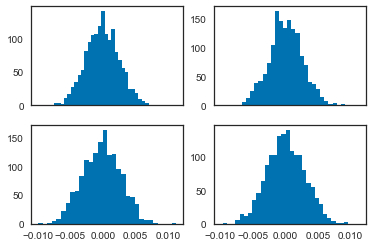

In [315]:
fig, ax = plt.subplots(2, 2, sharex=True)
eta_vertices_norm = eta_vertices.dot(np.diag(1/np.sqrt(np.sum(eta_vertices**2, axis=0))))
ax[0, 0].hist(eta_vertices[0:1500, 0], bins=30)
ax[0, 1].hist(eta_vertices[1500:, 0], bins=30)
ax[1, 0].hist(eta_vertices[0:1500, 1], bins=30)
ax[1, 1].hist(eta_vertices[1500:, 1], bins=30)


array([  4.40230558e-16,   1.93397542e-15,   9.84921995e-16,
         3.69979847e-15,   3.69613325e-15])

In [152]:
# run eigenvalue test

r_seed = 1234
np.random.seed(r_seed)

eigvals_dict= {}

theta_vals = [np.pi/6, np.pi/4, np.pi/3]
count =0
for theta in theta_vals:
    for ind, radius in enumerate([0.8, 1.2]):
        lam = radius*np.sin(theta)
        mu = radius*np.cos(theta)*np.sqrt(gamma)
        

        A, v = sbm_adjacency(n, d, lam)
        B, u = sbm_covariates(n, p, v, mu)
        nbW, row_inds, col_inds = nonbacktracking_from_adj(A)
        n_edges = len(row_inds)
        vert_from_edges = vertex_marginals_from_incoming_messages(A, row_inds, col_inds)
        edges_from_verts = dedge_messages_from_vertices(n, row_inds, col_inds)
        eigval_sp = spectral_HT(A, B, nbW, vert_from_edges, edges_from_verts, n, p, n_edges, lam, mu, d)
        
        eigvals_dict[(lam, mu)] = eigval_sp

        
        #axes[ind].set_aspect('box')
    


0.39999999999999997 0.692820323027551
0.5999999999999999 1.0392304845413265
0.565685424949238 0.5656854249492381
0.8485281374238569 0.848528137423857
0.6928203230275509 0.40000000000000013
1.0392304845413263 0.6000000000000001


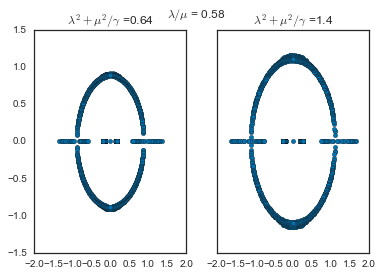

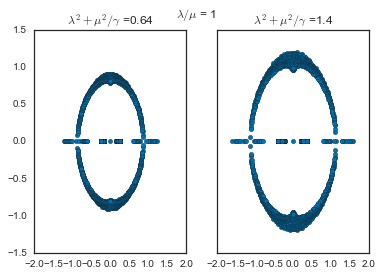

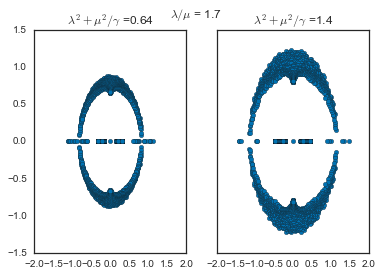

In [151]:
# plot eigenvalue test results

for theta in theta_vals:
    fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
    for ind, radius in enumerate([0.8, 1.2]):
        lam = radius*np.sin(theta)
        mu = radius*np.cos(theta)
        subplot_title = r'$\lambda^2 + \mu^2/\gamma$ ={0:.2g}'.format(lam**2 + mu**2/gamma)

        eigval_sp = eigvals_dict[(lam, mu)]
        axes[ind].scatter(eigval_sp.real, eigval_sp.imag)
        axes[ind].set_title(subplot_title)
        print lam, mu

        
    fig.suptitle(r'$\lambda/\mu$ = {0:.2g}'.format(np.tan(theta)))





In [144]:
eigvals_dict

{(0.39999999999999997,
  0.692820323027551): array([ 1.35571479+0.j, -1.3331187 +0.j, -1.3013506 +0.j, ...,
        -0.17888544+0.j,  0.17888544+0.j,  0.17888544+0.j]),
 (0.565685424949238,
  0.5656854249492381): array([ 1.22045281+0.j, -1.21537763+0.j, -1.19602522+0.j, ...,
        -0.25298221+0.j,  0.25298221+0.j,  0.25298221+0.j]),
 (0.5999999999999999,
  1.0392304845413265): array([ 1.67333857+0.j, -1.63159711+0.j,  1.62816137+0.j, ...,
        -0.26832816+0.j,  0.26832816+0.j,  0.26832816+0.j]),
 (0.6928203230275509,
  0.40000000000000013): array([ 1.11512875+0.j, -1.11916533+0.j, -1.10132139+0.j, ...,
        -0.30983867+0.j, -0.30983867+0.j, -0.30983867+0.j]),
 (0.8485281374238569,
  0.848528137423857): array([-1.59885068+0.j,  1.58547294+0.j,  1.56799427+0.j, ...,
         0.37947332+0.j,  0.37947332+0.j,  0.37947332+0.j]),
 (1.0392304845413263,
  0.6000000000000001): array([ 1.48328518+0.j, -1.4109434 +0.j, -1.4098833 +0.j, ...,
        -0.464758  +0.j,  0.464758  +0.j,  0.464

In [109]:
np.pi

3.141592653589793

(-1.5, 1.5, -1.5, 1.5)

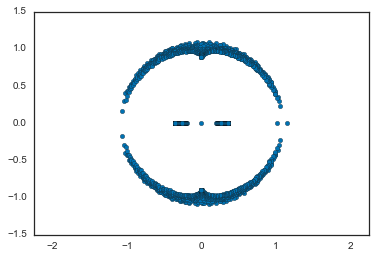

In [107]:

plt.scatter(eigval_sp.real, eigval_sp.imag)
plt.axis('equal')

In [39]:
mc_max = 500
corr = np.zeros(mc_max)
for mc_iter in range(mc_max):


    # initialize messages randomly
    eta_edge_t = np.random.randn(n_edges)
    eta_vert_t = np.random.randn(n)
    eta_vert_tm1 = np.random.randn(n)
    m_t = np.random.randn(p)
    m_tm1 = np.random.randn(p)

    # new message variables initialized below
    eta_edge_tp1 = np.zeros(n_edges)
    eta_vert_tp1 = np.zeros(n)
    m_tp1 = np.zeros(n)

    for iter_ind in range(t_max):
        # now iterate the equations:

        eta_edge_tp1 = nbW.dot(eta_edge_t)*lam/np.sqrt(d) + edges_from_verts.dot( - lam*np.sqrt(d)*np.mean(eta_vert_t)\
                                                                                - eta_vert_tm1*mu/gamma \
                                                                                + B.dot(m_t)*np.sqrt(mu/gamma) )
        eta_vert_tp1 = vert_from_edges.dot(eta_edge_t)*lam/np.sqrt(d)  - lam*np.sqrt(d)*np.mean(eta_vert_t)\
                                                                                - eta_vert_tm1*mu/gamma \
                                                                                + B.dot(m_t)*np.sqrt(mu/gamma) 
        m_tp1 = B.T.dot(eta_vert_t)*np.sqrt(mu/gamma) - m_tm1* mu

        # now update the variables t-1
        eta_vert_tm1 = eta_vert_t
        m_tm1 = m_t
        # now update the variables t
        eta_edge_t = eta_edge_tp1
        eta_vert_t = eta_vert_tp1
        m_t = m_tp1
        #end
        
    corr[mc_iter] =  np.abs(np.sign(eta_vert_tp1).dot(v))/n


(-221.4518389911442+0j)

In [1]:
import sys
sys.version

'2.7.11 |Anaconda 4.0.0 (x86_64)| (default, Dec  6 2015, 18:57:58) \n[GCC 4.2.1 (Apple Inc. build 5577)]'